In [1]:
import numpy as np
import dense_basis as db
import matplotlib.pyplot as plt
from astropy.table import Table
import time

print('using versions:')
print('numpy: ',np.__version__)
print('dense basis: ',db.__version__)

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
using versions:
numpy:  1.16.4
dense basis:  0.1.8


# import catalog and filter list

In [2]:
# Use your catalog here.

sed_cat = Table.read('fit_catalog.dat',format='ascii.commented_header')
sed_mags = sed_cat['niriss_f090w_magnitude', 
               'niriss_f115w_magnitude', 
               'niriss_f140m_magnitude',
               'niriss_f150w_magnitude',
               'niriss_f158m_magnitude',
               'niriss_f200w_magnitude',
               'niriss_f277w_magnitude',
               'niriss_f356w_magnitude',
               'niriss_f380m_magnitude',
               'niriss_f430m_magnitude',
               'niriss_f444w_magnitude',
               'niriss_f480m_magnitude']


sed_fnus = np.zeros((len(sed_mags), len(sed_mags[0])))
for i in range(len(sed_mags)):
    sed_mag_array = np.array([sed_mags.as_array()[i][ii] for ii in range(len(sed_mags.as_array()[i]))])
    sed_fnus[i,0:] = 10**((8.90 - sed_mag_array)/2.5) # convert to flux in Jansky
    sed_fnus[i,0:] = sed_fnus[i,0:] * 1e6 # convert to microJansky
    
sed_cat

index,x_or_RA,y_or_Dec,star_flag,niriss_f090w_magnitude,niriss_f115w_magnitude,niriss_f140m_magnitude,niriss_f150w_magnitude,niriss_f158m_magnitude,niriss_f200w_magnitude,niriss_f277w_magnitude,niriss_f356w_magnitude,niriss_f380m_magnitude,niriss_f430m_magnitude,niriss_f444w_magnitude,niriss_f480m_magnitude,radius,sersic_index,ellipticity,pos_angle
int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,81.1330243648446,-70.08435848187852,1,22.3172,21.2307,20.8545,20.7759,20.7102,20.4522,20.2287,20.1341,20.0939,20.0542,20.1302,20.2349,0.2077,0.4366,0.5315,329.5995
2,81.05599938415182,-70.07488739072602,1,26.3135,25.0896,24.7686,24.7069,24.6557,24.4212,24.158,24.058,24.0298,23.8606,23.9733,24.0668,0.1005,1.9566,0.618,232.2183
3,81.1067876056524,-70.08731011040538,1,24.5573,23.153,22.5868,22.4619,22.358,21.9548,21.5007,21.3012,21.2414,21.0826,21.1847,21.2778,0.0992,2.501,0.7965,156.1685
4,81.03853633360723,-70.0903021202921,1,25.1066,23.7561,23.2122,23.0873,22.986,22.5985,22.1597,21.9634,21.9148,21.7579,21.8538,21.9423,0.1242,0.9721,0.4129,350.0025
5,81.13347342259219,-70.0933403359421,1,24.1653,22.8436,22.3234,22.2077,22.1147,21.7683,21.3753,21.2187,21.1841,21.0154,21.1223,21.2294,0.1469,2.1143,0.3883,232.4644
6,81.12992792012821,-70.10202573555746,1,24.7657,23.5061,23.0145,22.9029,22.813,22.4895,22.0954,21.9502,21.9259,21.7579,21.8626,21.9715,0.0752,1.2027,0.7598,115.4208
7,81.1250235021257,-70.09936342139424,1,25.1842,23.8259,23.2719,23.1386,23.031,22.6458,22.2019,22.0034,21.9684,21.7958,21.8827,21.9635,0.1545,1.7754,0.706,139.3677
8,81.13601714520377,-70.10173360081764,1,23.9352,22.6503,22.1301,22.0103,21.9132,21.5982,21.2408,21.1117,21.095,20.9414,21.0298,21.1284,0.1871,1.7355,0.387,251.8958
9,81.06241341182667,-70.08213709190473,1,25.8668,24.5822,24.0581,23.9344,23.8325,23.5184,23.1623,23.0188,23.0253,22.8747,22.9227,22.9918,0.1464,0.1212,0.2513,228.9505


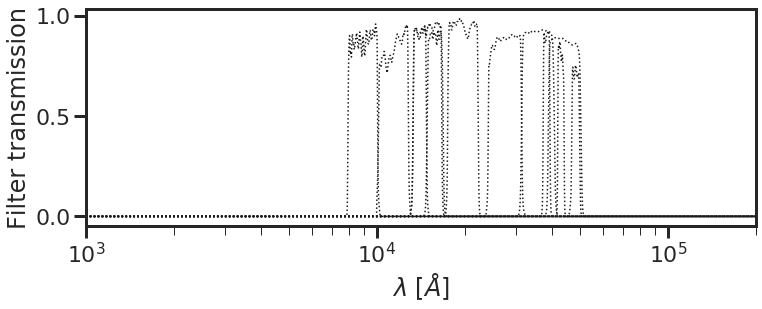

In [3]:
# The filter list contains a list of the filenames correpsonding to each filter transmission curve
# and sits in the filt_dir folder 

filter_list = 'filter_list_canucs.txt'
filt_dir = 'filtercurves/' # path to directory containing filter list
db.plot_filterset(filter_list = filter_list, filt_dir = filt_dir)

# define priors and generate atlas

In [4]:
# Priors class, to see all the options look in the priors.py file in the dense_basis folder
priors = db.Priors()

# SFH priors
priors.Nparam = 3
priors.tx_alpha = np.ones((priors.Nparam+1,))*5.0
priors.tx_alpha[0] = 22

# SFR prior
priors.sfr_prior_type = 'sSFRlognormal'
priors.ssfr_mean = 1.2
priors.ssfr_sigma = 0.4
priors.ssfr_shift = -0.7
priors.dynamic_decouple = True

# metallicity prior
priors.Z_min = -1.0
priors.Z_max = 0.25

# dust prior
priors.dust_prior = 'exp'
priors.Av_exp_scale = 1.0/5.0

# redshift prior
priors.z_min = 1.25
priors.z_max = 2.0

In [5]:
N_pregrid = 100000 # size of the precomputed atlas (it's recommended to use at least 10k)
fname = 'canucs_test_v2'
atlaspath = 'atlas/'

# try:
#     # if there's already a precomputed atlas, just use that
#     atlas = db.load_atlas(fname, N_pregrid, priors.Nparam, path=atlaspath)
    
# except:
db.generate_atlas(N_pregrid = N_pregrid, priors = priors, 
                fname = fname, store=True, norm_method = 'median', path=atlaspath,
                filter_list = filter_list, filt_dir = filt_dir)

atlas = db.load_atlas(fname, N_pregrid, priors.Nparam, path=atlaspath)

db.plot_atlas_priors(atlas) # plot the effective priors given the precomputed atlas

  0%|          | 0/100000 [00:00<?, ?it/s]

generating atlas with: 
3  tx parameters,  sSFRlognormal  SFR sampling custom  SFH treatment flat  met sampling Calzetti  dust attenuation exp  dust prior False  SFR decoupling.


 96%|█████████▌| 95967/100000 [1:30:55<03:40, 18.26it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# fitting individual galaxies

In [6]:
gal_id = 4
SNR = 30

sed = sed_fnus[gal_id,0:]
sed_err = sed/SNR
# sed_err = sed_err + 0.1

In [7]:
time_start = time.time()

#sedfit = db.SedFit(sed, sed_err, atlas, zbest = 1.54, deltaz=0.05)
sedfit = db.SedFit(sed, sed_err, atlas)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

time_end = time.time()

print('time taken: %.2f sec' %(time_end-time_start))

time taken: 0.23 sec


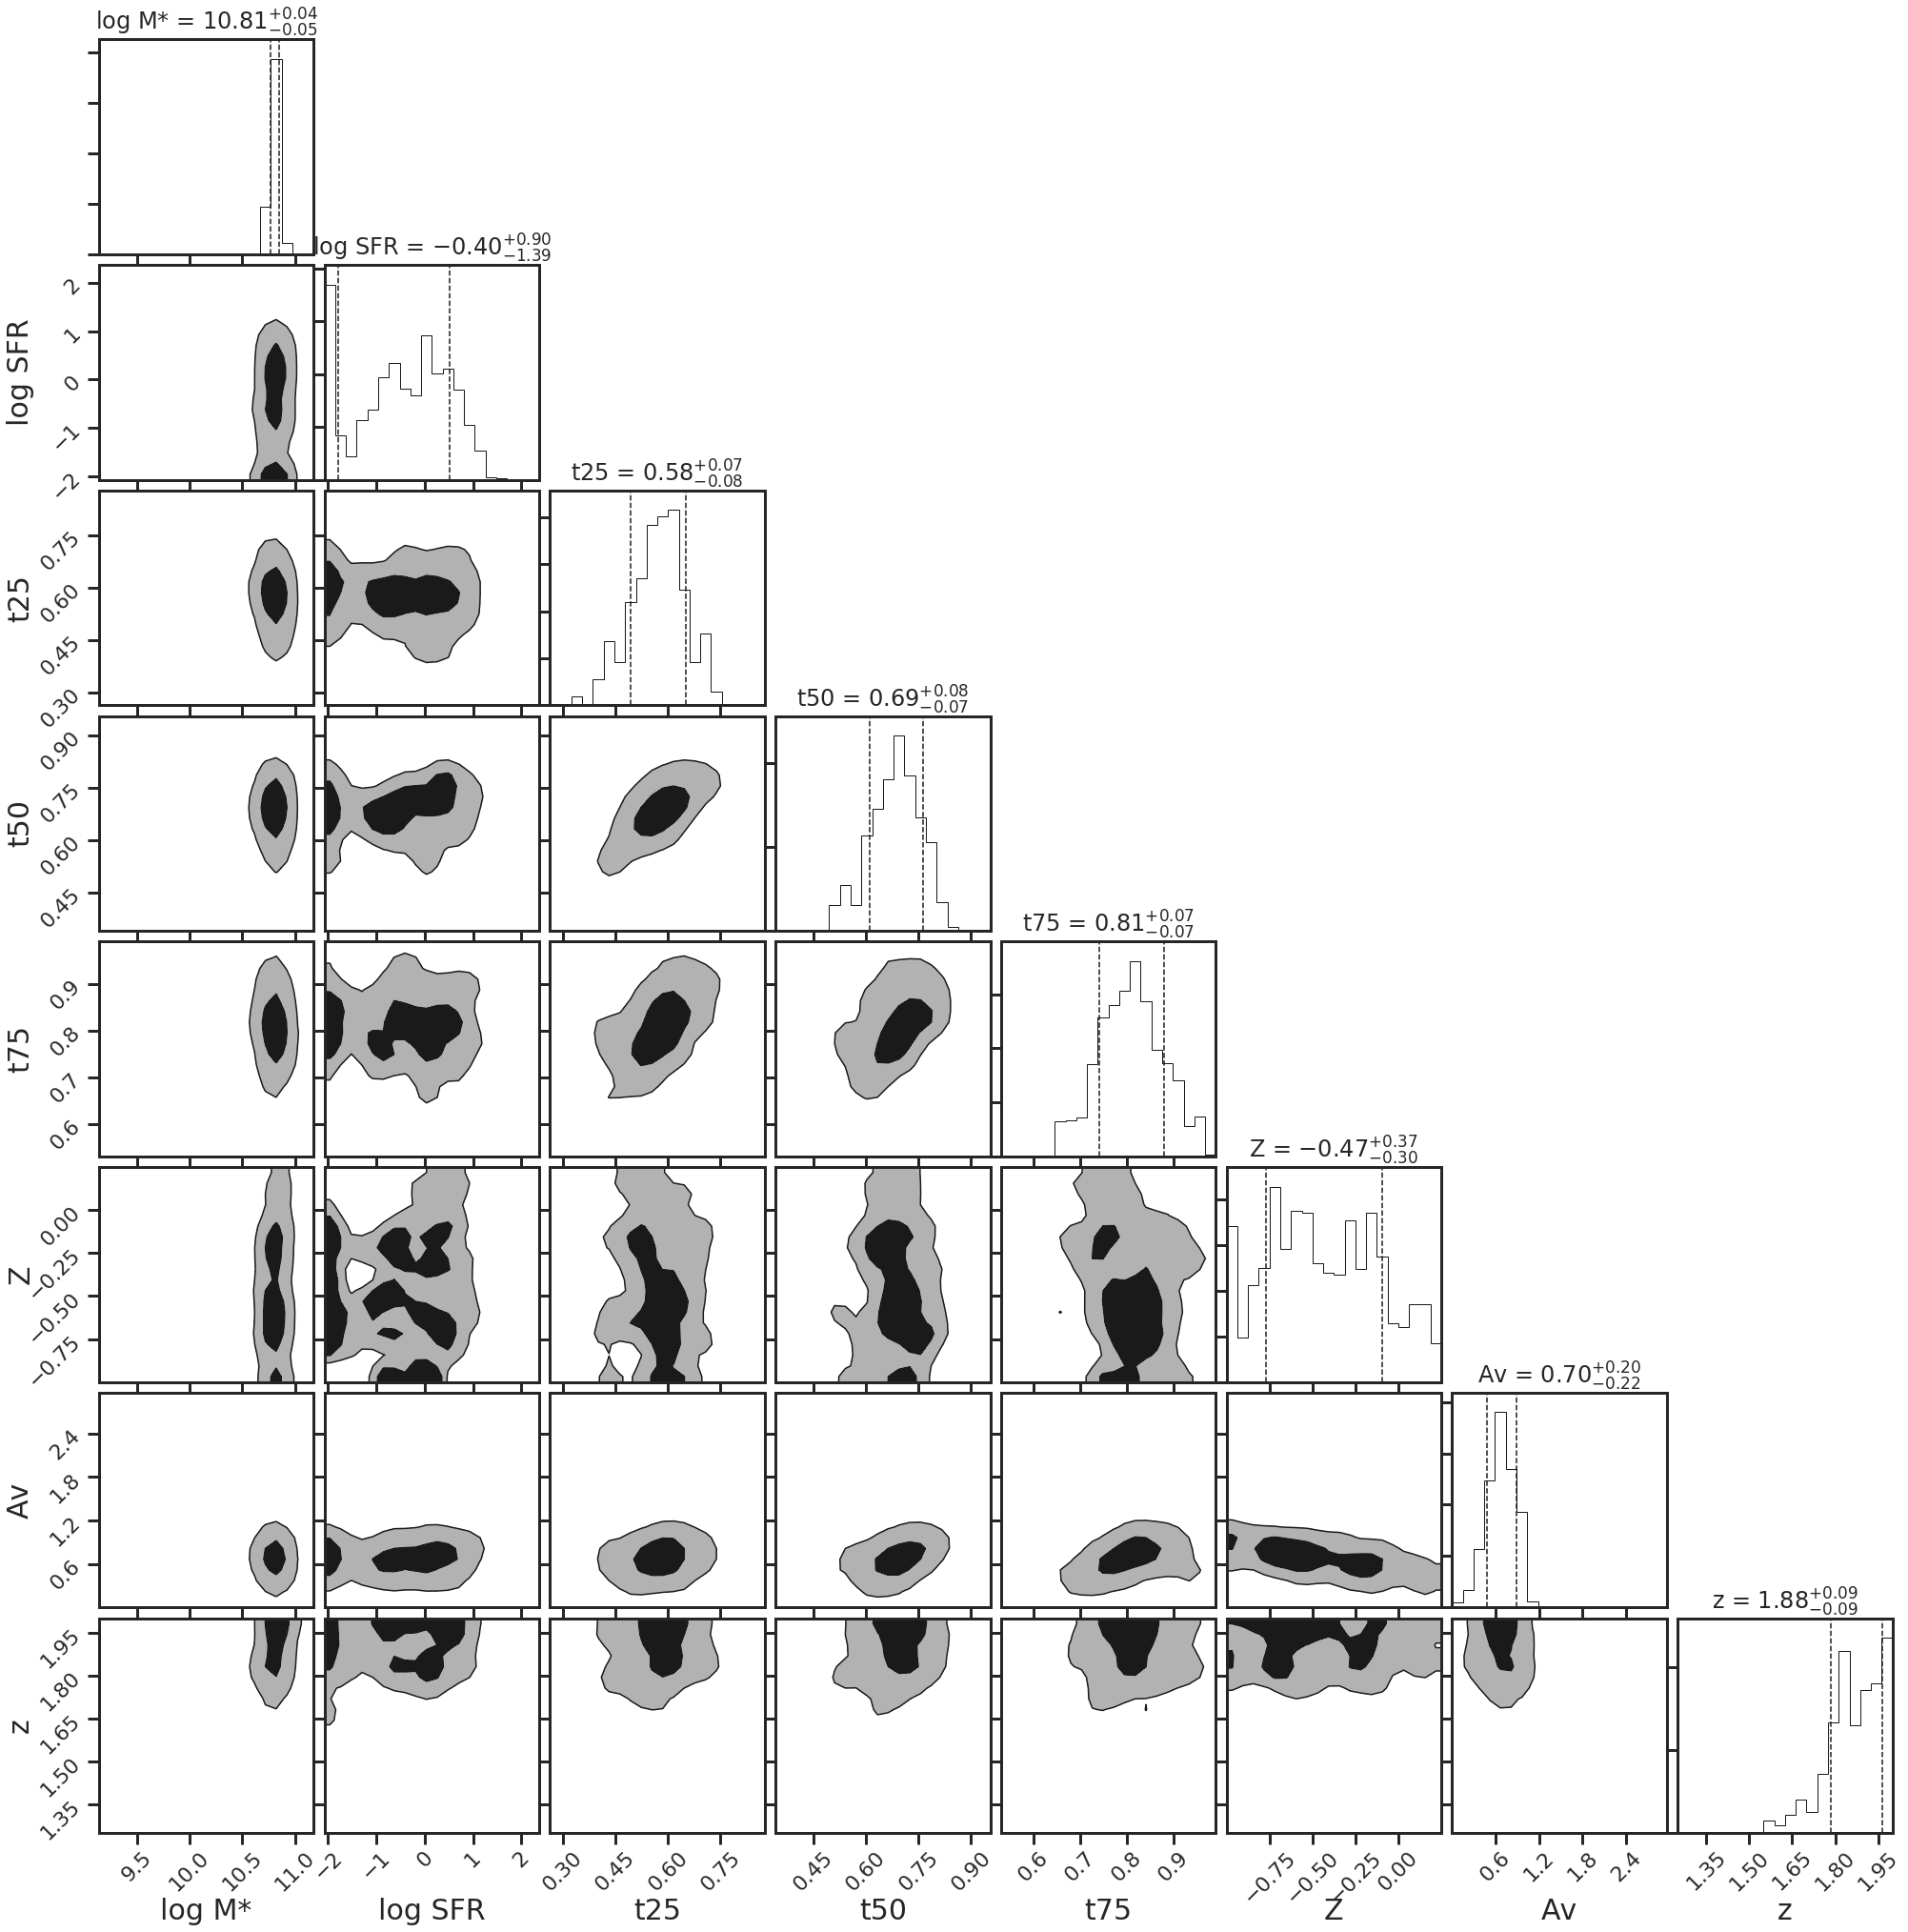

In [8]:
sedfit.plot_posteriors()
plt.show()

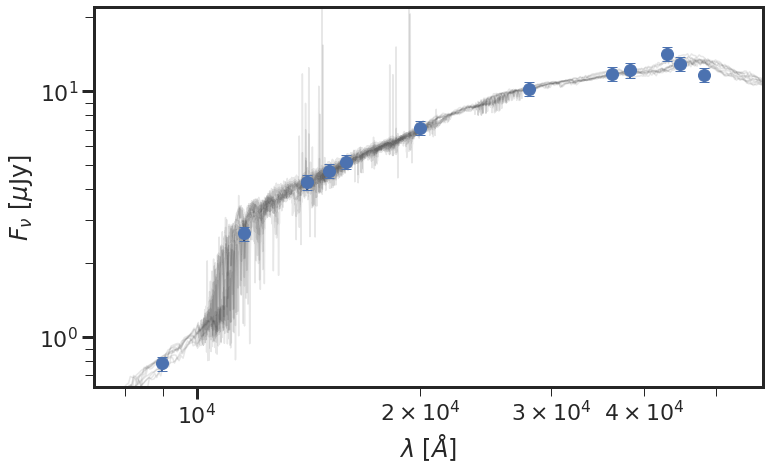

In [9]:
filt_centers = np.array([8968,11584,14072,15081,15900,19982,28000,36251,38298,42869,44718,48195])

figure = sedfit.plot_posterior_spec(filt_centers, priors, ngals = 10)
plt.show()

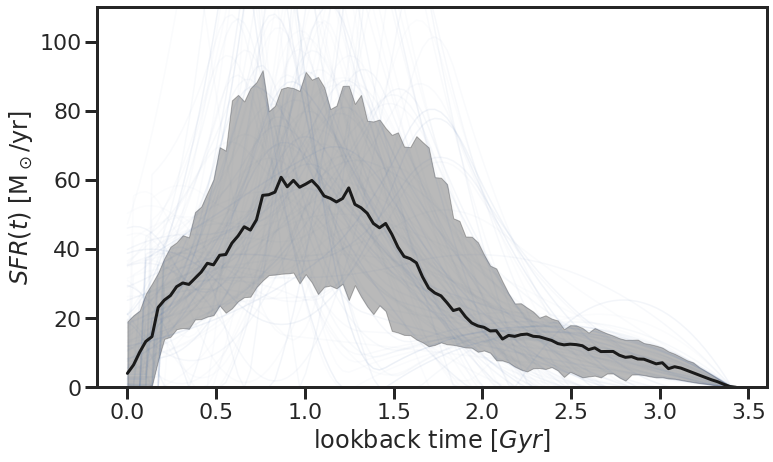

In [10]:
figure = sedfit.plot_posterior_SFH(sedfit.z[0],ngals = 100)
plt.show()

In [11]:
def fit_catalog(catalog, snrval = 30):
    
    n_gals = catalog.shape[0]
    
    mstar_vals = np.zeros((n_gals, 3))
    sfr_vals = np.zeros((n_gals, 3))
    z_vals = np.zeros((n_gals, 3))
    Av_vals = np.zeros((n_gals, 3))
    
    for i in range(n_gals):
        
        SNR = snrval

        sed = sed_fnus[i,0:]
        sed_err = sed/SNR
#         sed_err = sed_err + 0.1
        
        sedfit = db.SedFit(sed, sed_err, atlas)
        sedfit.evaluate_likelihood()
        sedfit.evaluate_posterior_percentiles()
        
        mstar_vals[i,0:] = sedfit.mstar # outputs 3 values - [50. 16. 84.] percentiles
        sfr_vals[i,0:] = sedfit.sfr # outputs 3 values - [50. 16. 84.] percentiles
        z_vals[i,0:] = sedfit.z # outputs 3 values - [50. 16. 84.] percentiles
        Av_vals[i,0:] = sedfit.Av
        
    return mstar_vals, sfr_vals, z_vals, Av_vals

time taken to fit catalog: 4.23 sec


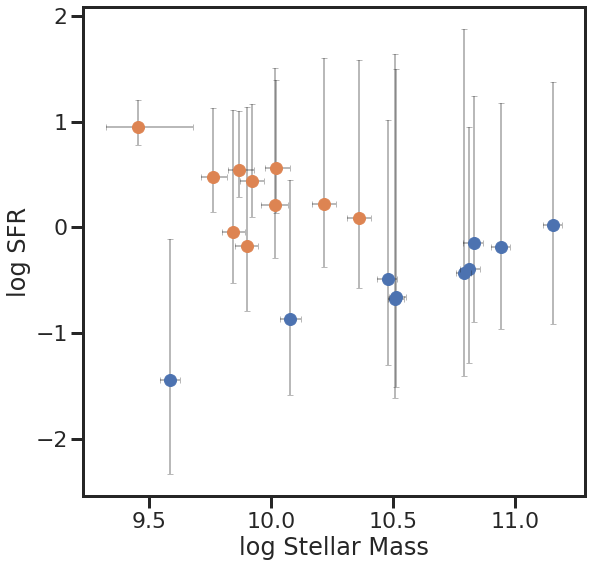

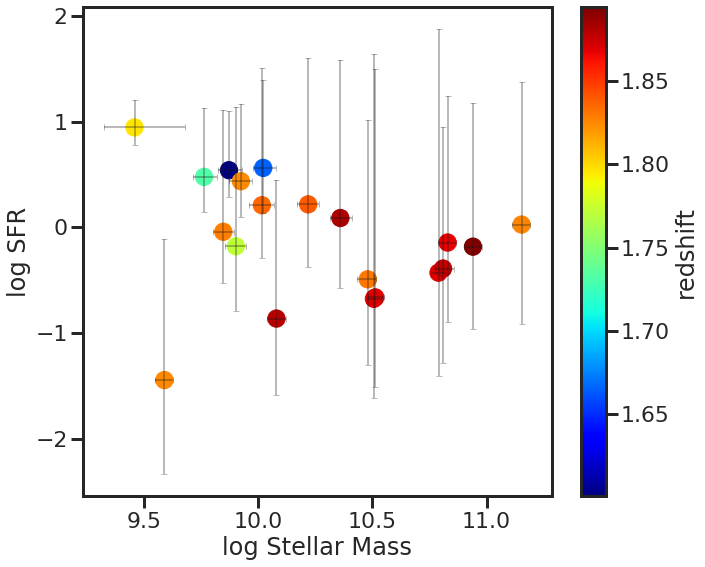

In [12]:
time_start = time.time()

mstar_vals, sfr_vals, z_vals, Av_vals = fit_catalog(sed_fnus, snrval = 30)

time_end = time.time()

print('time taken to fit catalog: %.2f sec' %(time_end-time_start))

plt.figure(figsize=(9,9))
plt.plot(mstar_vals[0:10,0], sfr_vals[0:10,0],'o',markersize=12)
plt.plot(mstar_vals[10:,0], sfr_vals[10:,0],'o',markersize=12)
xerr_up = mstar_vals[0:,2] - mstar_vals[0:,0]
xerr_dn = mstar_vals[0:,0] - mstar_vals[0:,1]
yerr_up = sfr_vals[0:,2] - sfr_vals[0:,0]
yerr_dn = sfr_vals[0:,0] - sfr_vals[0:,1]
plt.errorbar(mstar_vals[0:,0], sfr_vals[0:,0],xerr = (xerr_up, xerr_dn), yerr = (yerr_up,yerr_dn),
            lw=0,elinewidth=2,capsize=3,alpha=0.3,color='k')
plt.xlabel('log Stellar Mass');plt.ylabel('log SFR')
plt.show()


plt.figure(figsize=(10.5,9))
plt.scatter(mstar_vals[0:,0], sfr_vals[0:,0],s=300, c=z_vals[0:,0],cmap='jet')
clbr = plt.colorbar(); clbr.set_label('redshift')
xerr_up = mstar_vals[0:,2] - mstar_vals[0:,0]
xerr_dn = mstar_vals[0:,0] - mstar_vals[0:,1]
yerr_up = sfr_vals[0:,2] - sfr_vals[0:,0]
yerr_dn = sfr_vals[0:,0] - sfr_vals[0:,1]
plt.errorbar(mstar_vals[0:,0], sfr_vals[0:,0],xerr = (xerr_up, xerr_dn), yerr = (yerr_up,yerr_dn),
            lw=0,elinewidth=2,capsize=3,alpha=0.3,color='k')
plt.xlabel('log Stellar Mass');plt.ylabel('log SFR')
plt.show()

In [13]:
fit_mdict = {'mstar_50': mstar_vals[0:,0],'mstar_16': mstar_vals[0:,1],'mstar_84': mstar_vals[0:,2], 
             'sfr_50': sfr_vals[0:,0],'sfr_16': sfr_vals[0:,1],'sfr_84': sfr_vals[0:,2],
             'Av_50':Av_vals[0:,0], 'Av_16': Av_vals[0:,1], 'Av_84': Av_vals[0:,2],
             'redshift_50': z_vals[0:,0],'redshift_16': z_vals[0:,1],'redshift_84': z_vals[0:,2]}

db_fits = Table(data = fit_mdict)
try:
    db_fits.write('db_fits_v2_snr_30.fits', overwrite = True)
except:
    print('file already exists')

In [14]:
snrvals = 10**np.arange(0.25,3.0,0.25)
snrvals

array([  1.77827941,   3.16227766,   5.62341325,  10.        ,
        17.7827941 ,  31.6227766 ,  56.23413252, 100.        ,
       177.827941  , 316.22776602, 562.34132519])

In [15]:
for snr in snrvals:

    time_start = time.time()

    mstar_vals, sfr_vals, z_vals, Av_vals = fit_catalog(sed_fnus, snrval = snr)

    time_end = time.time()

    print('time taken to fit catalog: %.2f sec' %(time_end-time_start))
    
    fit_mdict = {'mstar_50': mstar_vals[0:,0],'mstar_16': mstar_vals[0:,1],'mstar_84': mstar_vals[0:,2], 
             'sfr_50': sfr_vals[0:,0],'sfr_16': sfr_vals[0:,1],'sfr_84': sfr_vals[0:,2],
             'Av_50':Av_vals[0:,0], 'Av_16': Av_vals[0:,1], 'Av_84': Av_vals[0:,2],
             'redshift_50': z_vals[0:,0],'redshift_16': z_vals[0:,1],'redshift_84': z_vals[0:,2]}

    db_fits = Table(data = fit_mdict)
    try:
        db_fits.write('db_fits_v2_snr_%.0f.fits' %snr, overwrite=True)
    except:
        print('file already exists')

time taken to fit catalog: 3.96 sec
time taken to fit catalog: 4.02 sec
time taken to fit catalog: 4.03 sec
time taken to fit catalog: 4.21 sec
time taken to fit catalog: 4.15 sec
time taken to fit catalog: 4.25 sec
time taken to fit catalog: 5.74 sec
time taken to fit catalog: 6.56 sec
time taken to fit catalog: 5.93 sec
time taken to fit catalog: 10.87 sec
time taken to fit catalog: 17.85 sec


# make plots of physical parameters as a function of SNR:

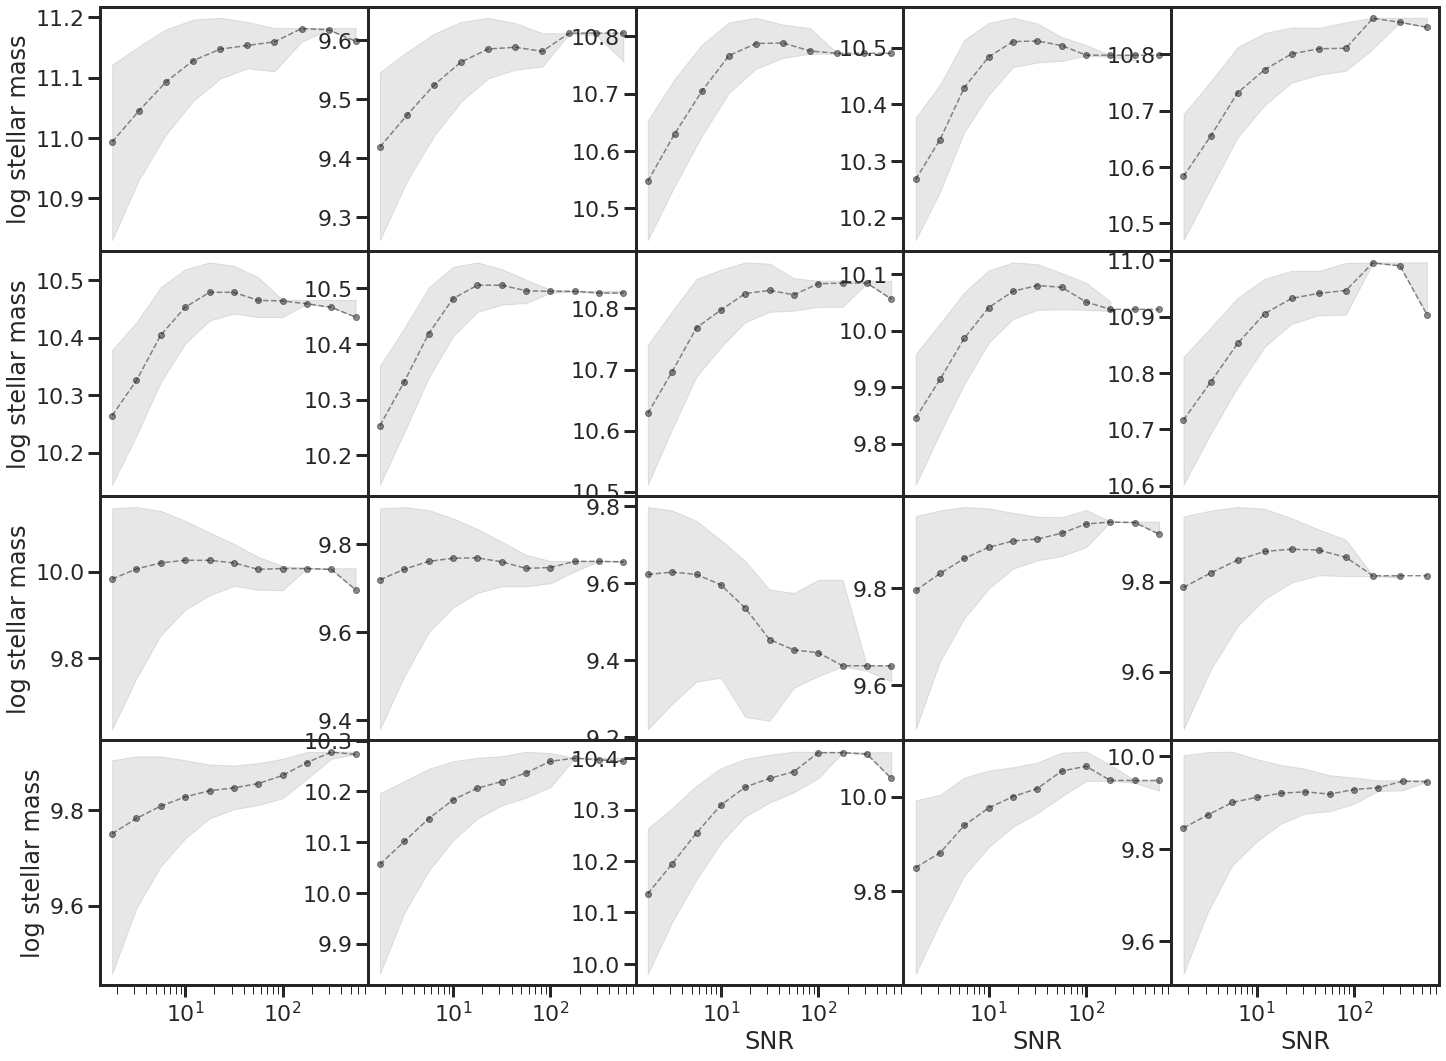

In [16]:
mstar_50_snr, mstar_16_snr, mstar_84_snr = [], [], []
sfr_50_snr, sfr_16_snr, sfr_84_snr = [], [], []
Av_50_snr, Av_16_snr, Av_84_snr = [], [], []
redshift_50_snr, redshift_16_snr, redshift_84_snr = [], [], []

for snr in snrvals:

    db_fits = Table.read('db_fits_v2_snr_%.0f.fits' %snr)
    mstar_50_snr.append(db_fits['mstar_50'])
    mstar_16_snr.append(db_fits['mstar_16'])
    mstar_84_snr.append(db_fits['mstar_84'])
    sfr_50_snr.append(db_fits['sfr_50'])
    sfr_16_snr.append(db_fits['sfr_16'])
    sfr_84_snr.append(db_fits['sfr_84'])
    Av_50_snr.append(db_fits['Av_50'])
    Av_16_snr.append(db_fits['Av_16'])
    Av_84_snr.append(db_fits['Av_84'])
    redshift_50_snr.append(db_fits['redshift_50'])
    redshift_16_snr.append(db_fits['redshift_16'])
    redshift_84_snr.append(db_fits['redshift_84'])
    
mstar_50_snr = np.array(mstar_50_snr)
mstar_16_snr = np.array(mstar_16_snr)
mstar_84_snr = np.array(mstar_84_snr)
sfr_50_snr = np.array(sfr_50_snr)
sfr_16_snr = np.array(sfr_16_snr)
sfr_84_snr = np.array(sfr_84_snr)
Av_50_snr = np.array(Av_50_snr)
Av_16_snr = np.array(Av_16_snr)
Av_84_snr = np.array(Av_84_snr)
redshift_50_snr = np.array(redshift_50_snr)
redshift_16_snr = np.array(redshift_16_snr)
redshift_84_snr = np.array(redshift_84_snr)

plt.subplots(4,5,figsize=(24,18))
plt.subplots_adjust(hspace=0, wspace=0)
for galid in range(20):
    plt.subplot(4,5,galid+1)
    plt.plot(snrvals, mstar_50_snr[0:,galid],'ko--',alpha=0.5)
    plt.fill_between(snrvals, mstar_16_snr[0:,galid],mstar_84_snr[0:,galid],color='k',alpha=0.1)
    plt.xscale('log')
    if galid%5 == 0:
        plt.ylabel('log stellar mass')
    if galid > 16:
        plt.xlabel('SNR');
plt.show()

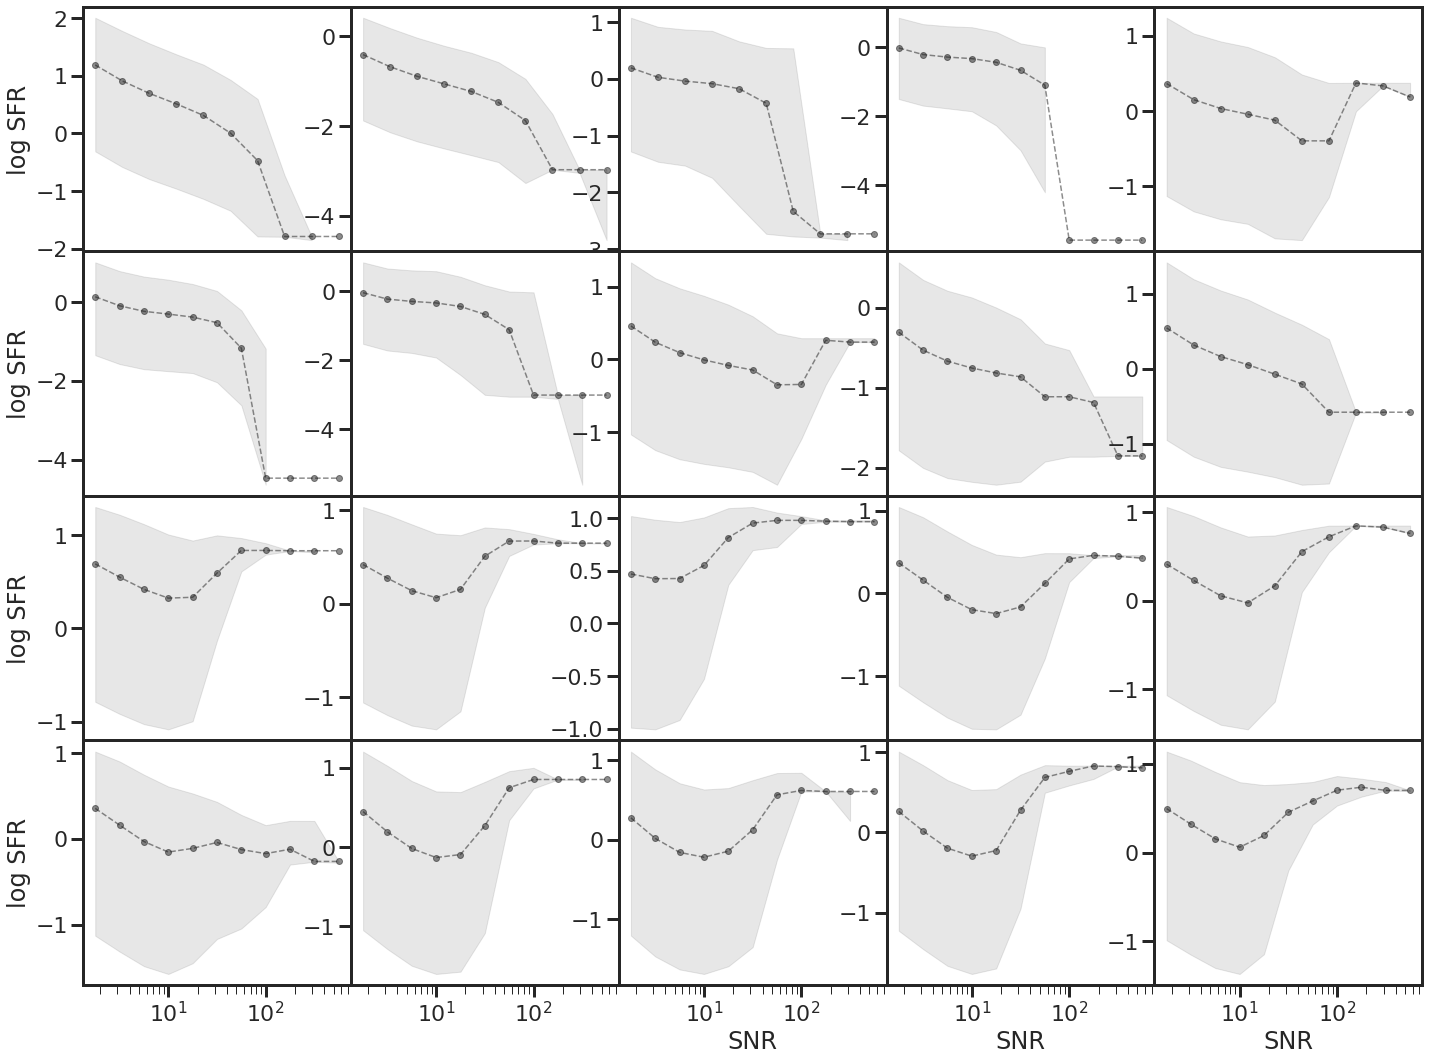

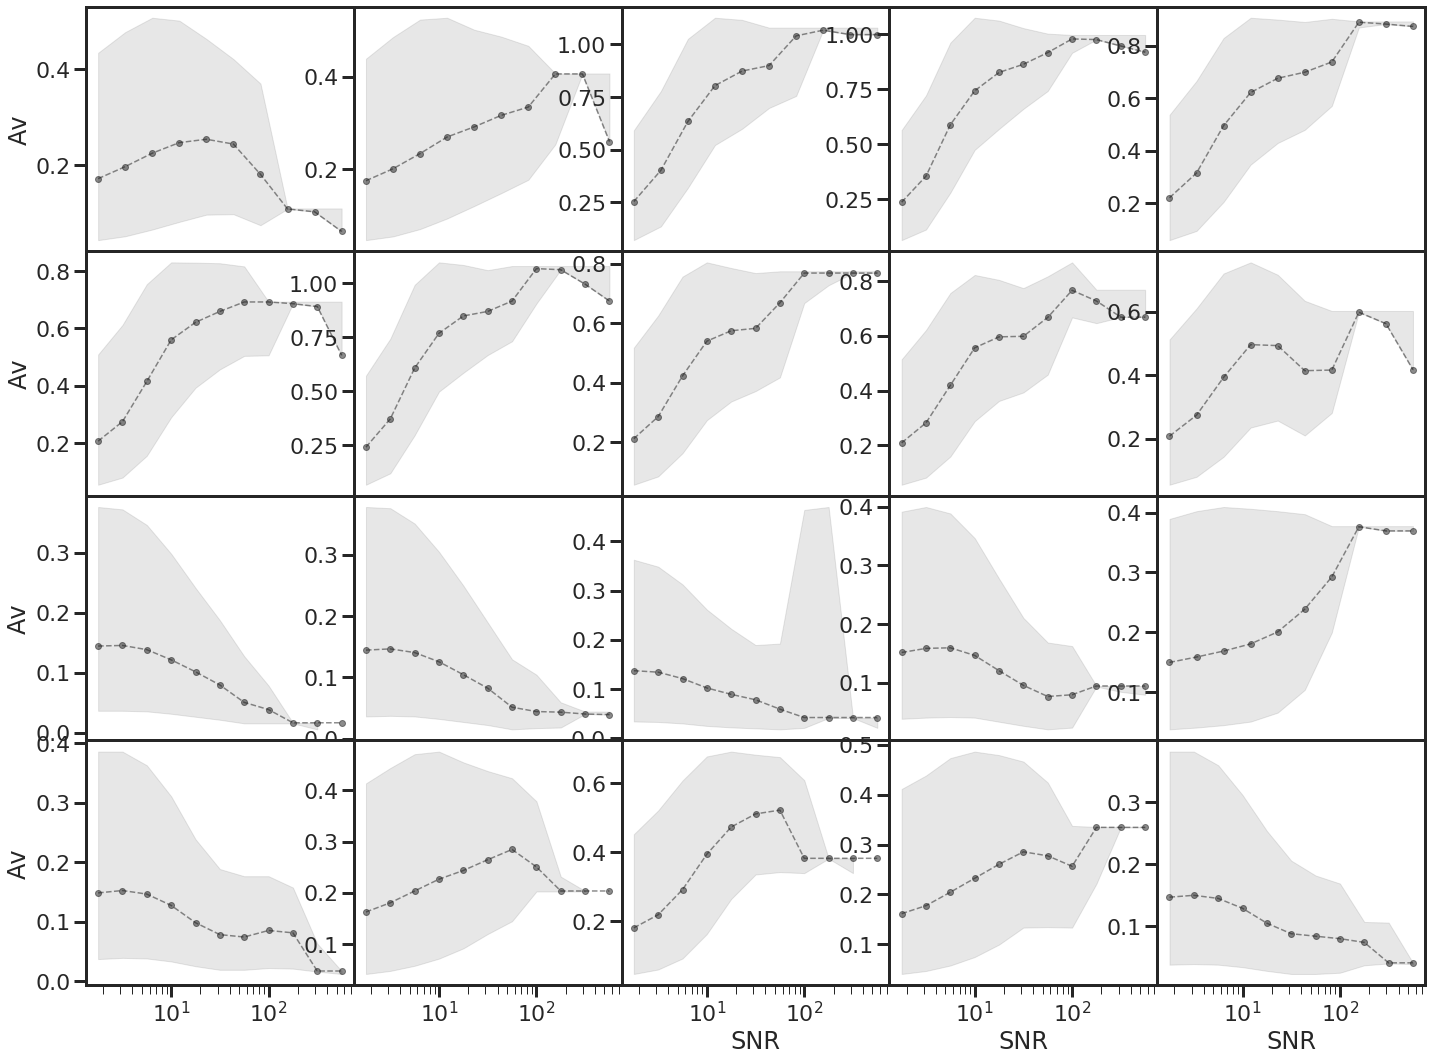

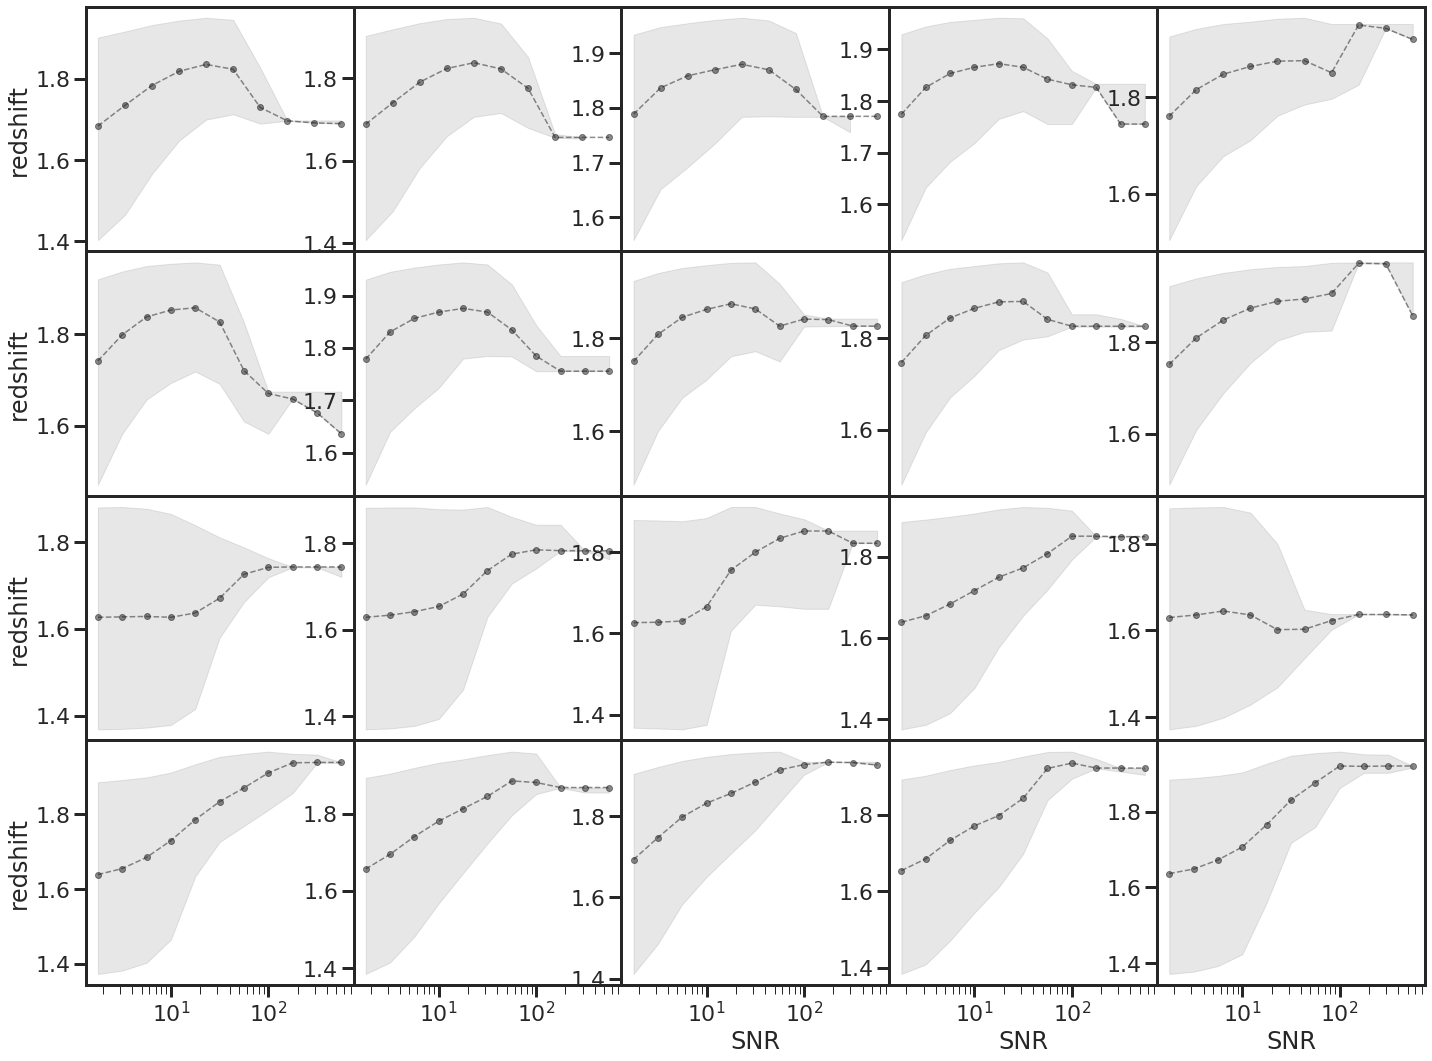

In [17]:
plt.subplots(4,5,figsize=(24,18))
plt.subplots_adjust(hspace=0, wspace=0)
for galid in range(20):
    plt.subplot(4,5,galid+1)
    plt.plot(snrvals, sfr_50_snr[0:,galid],'ko--',alpha=0.5)
    plt.fill_between(snrvals, sfr_16_snr[0:,galid],sfr_84_snr[0:,galid],color='k',alpha=0.1)
    plt.xscale('log')
    if galid%5 == 0:
        plt.ylabel('log SFR')
    if galid > 16:
        plt.xlabel('SNR');
plt.show()

plt.subplots(4,5,figsize=(24,18))
plt.subplots_adjust(hspace=0, wspace=0)
for galid in range(20):
    plt.subplot(4,5,galid+1)
    plt.plot(snrvals, Av_50_snr[0:,galid],'ko--',alpha=0.5)
    plt.fill_between(snrvals, Av_16_snr[0:,galid],Av_84_snr[0:,galid],color='k',alpha=0.1)
    plt.xscale('log')
    if galid%5 == 0:
        plt.ylabel('Av')
    if galid > 16:
        plt.xlabel('SNR');
plt.show()

plt.subplots(4,5,figsize=(24,18))
plt.subplots_adjust(hspace=0, wspace=0)
for galid in range(20):
    plt.subplot(4,5,galid+1)
    plt.plot(snrvals, redshift_50_snr[0:,galid],'ko--',alpha=0.5)
    plt.fill_between(snrvals, redshift_16_snr[0:,galid],redshift_84_snr[0:,galid],color='k',alpha=0.1)
    plt.xscale('log')
    if galid%5 == 0:
        plt.ylabel('redshift')
    if galid > 16:
        plt.xlabel('SNR');
plt.show()

# exploring why the quiescent galaxy redshifts are a bit off.

- is it a SFH thing? there aren't models that allow for SFHs that are quite linexp-like, so it can't get the required depth of the 4000A break.

time taken: 0.23 sec


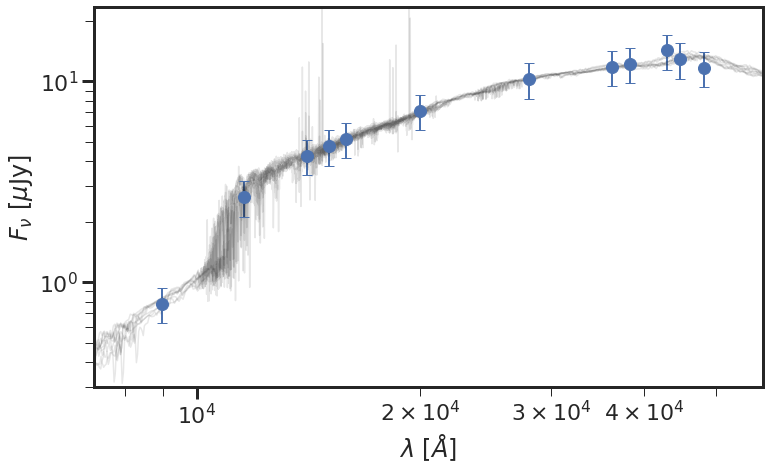

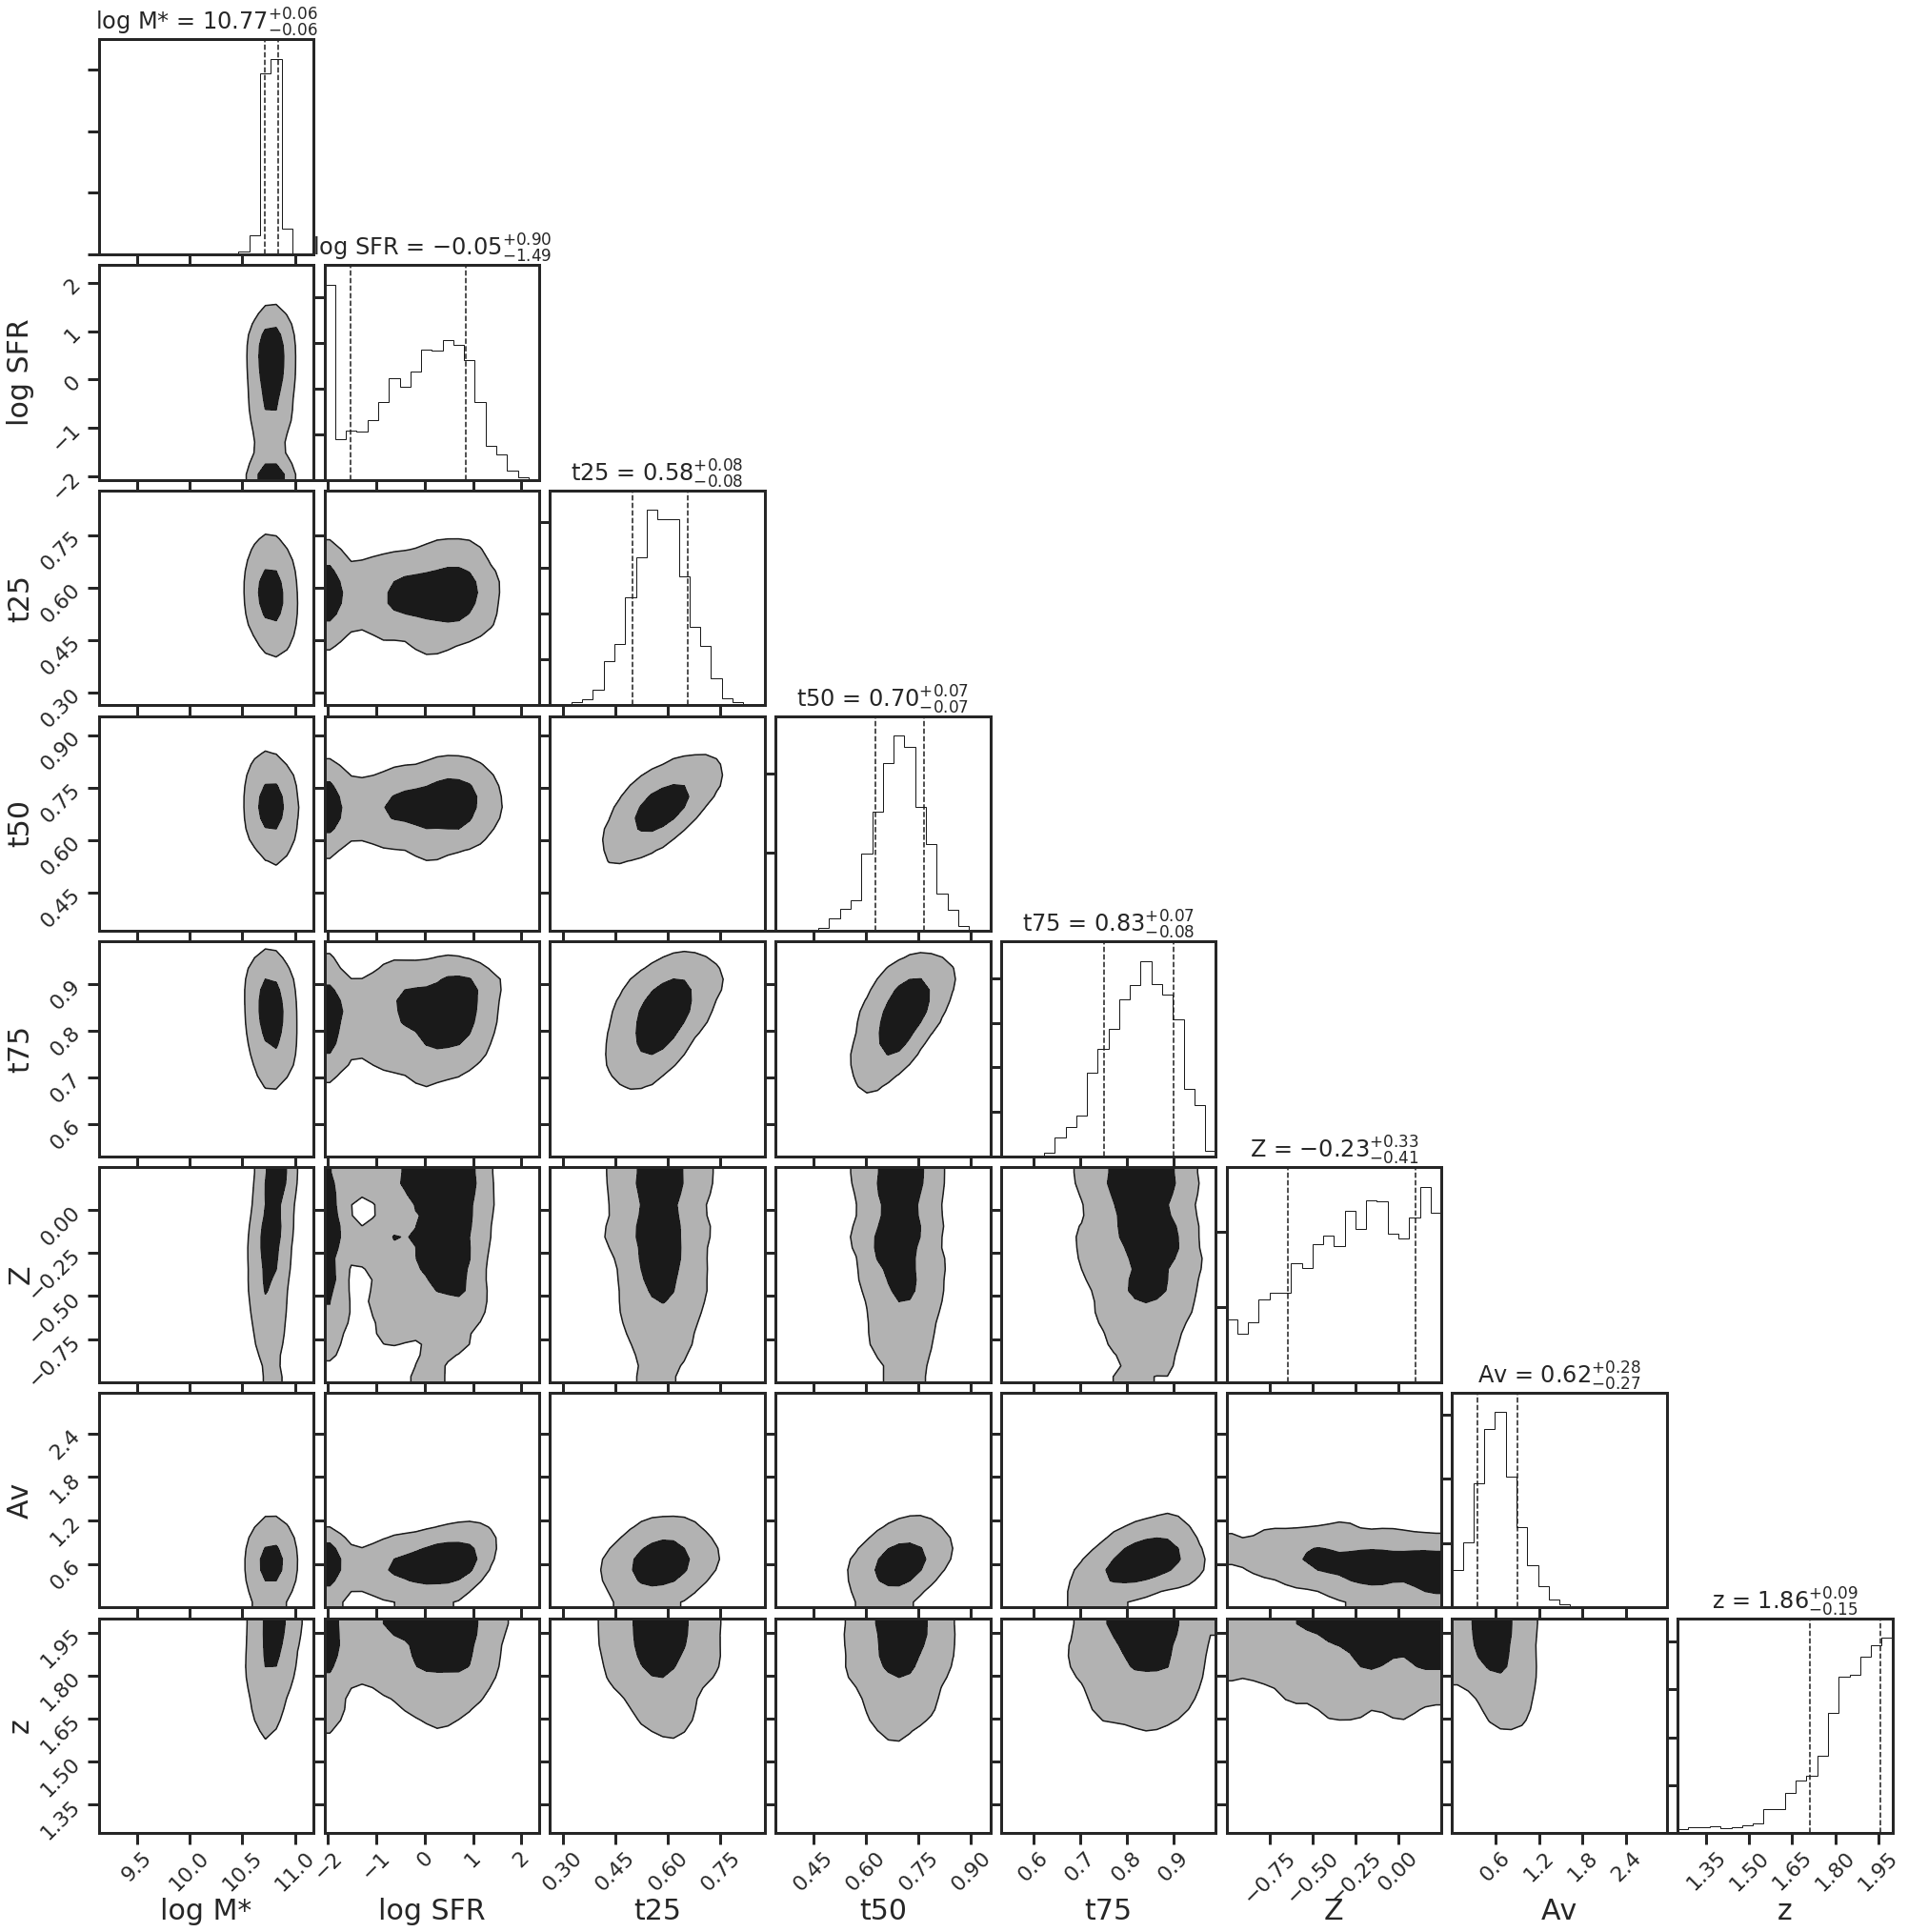

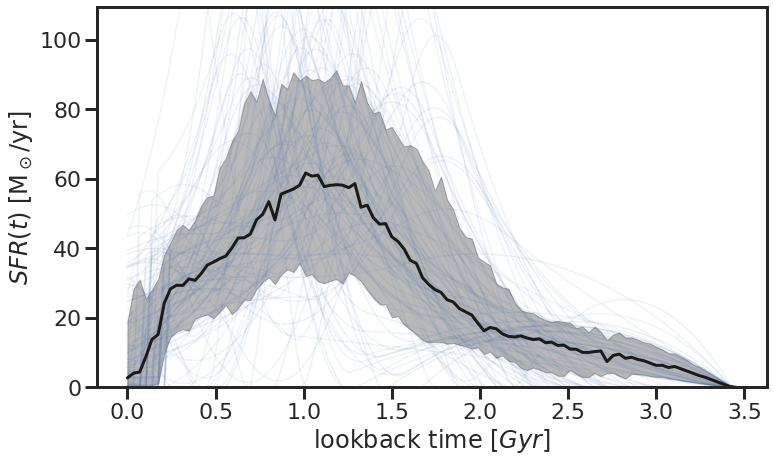

In [37]:
gal_id = 4
SNR = 10

sed = sed_fnus[gal_id,0:]
sed_err = sed/SNR
#sed_err = sed_err + 0.01

time_start = time.time()

#sedfit = db.SedFit(sed, sed_err, atlas, zbest = 1.50, deltaz=0.1)
sedfit = db.SedFit(sed, sed_err, atlas)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

time_end = time.time()

print('time taken: %.2f sec' %(time_end-time_start))

filt_centers = np.array([8968,11584,14072,15081,15900,19982,28000,36251,38298,42869,44718,48195])

figure = sedfit.plot_posterior_spec(filt_centers, priors, ngals = 10)
plt.ylim(3e-1,)
plt.show()

sedfit.plot_posteriors()
plt.show()

figure = sedfit.plot_posterior_SFH(sedfit.z[0],ngals = 100)
plt.show()

time taken: 0.23 sec


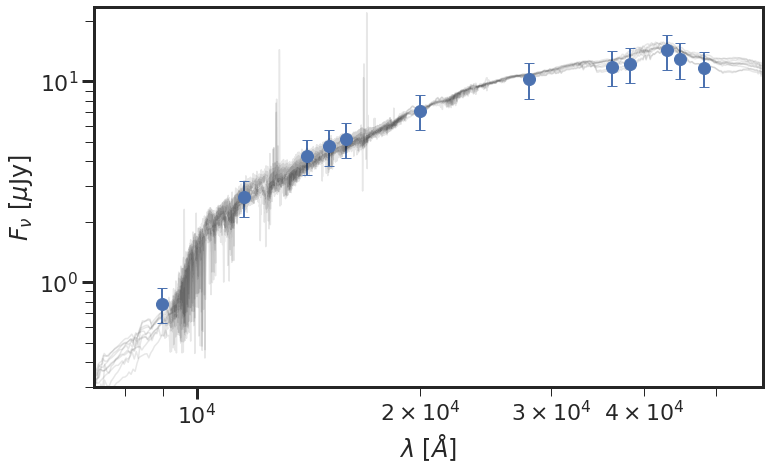

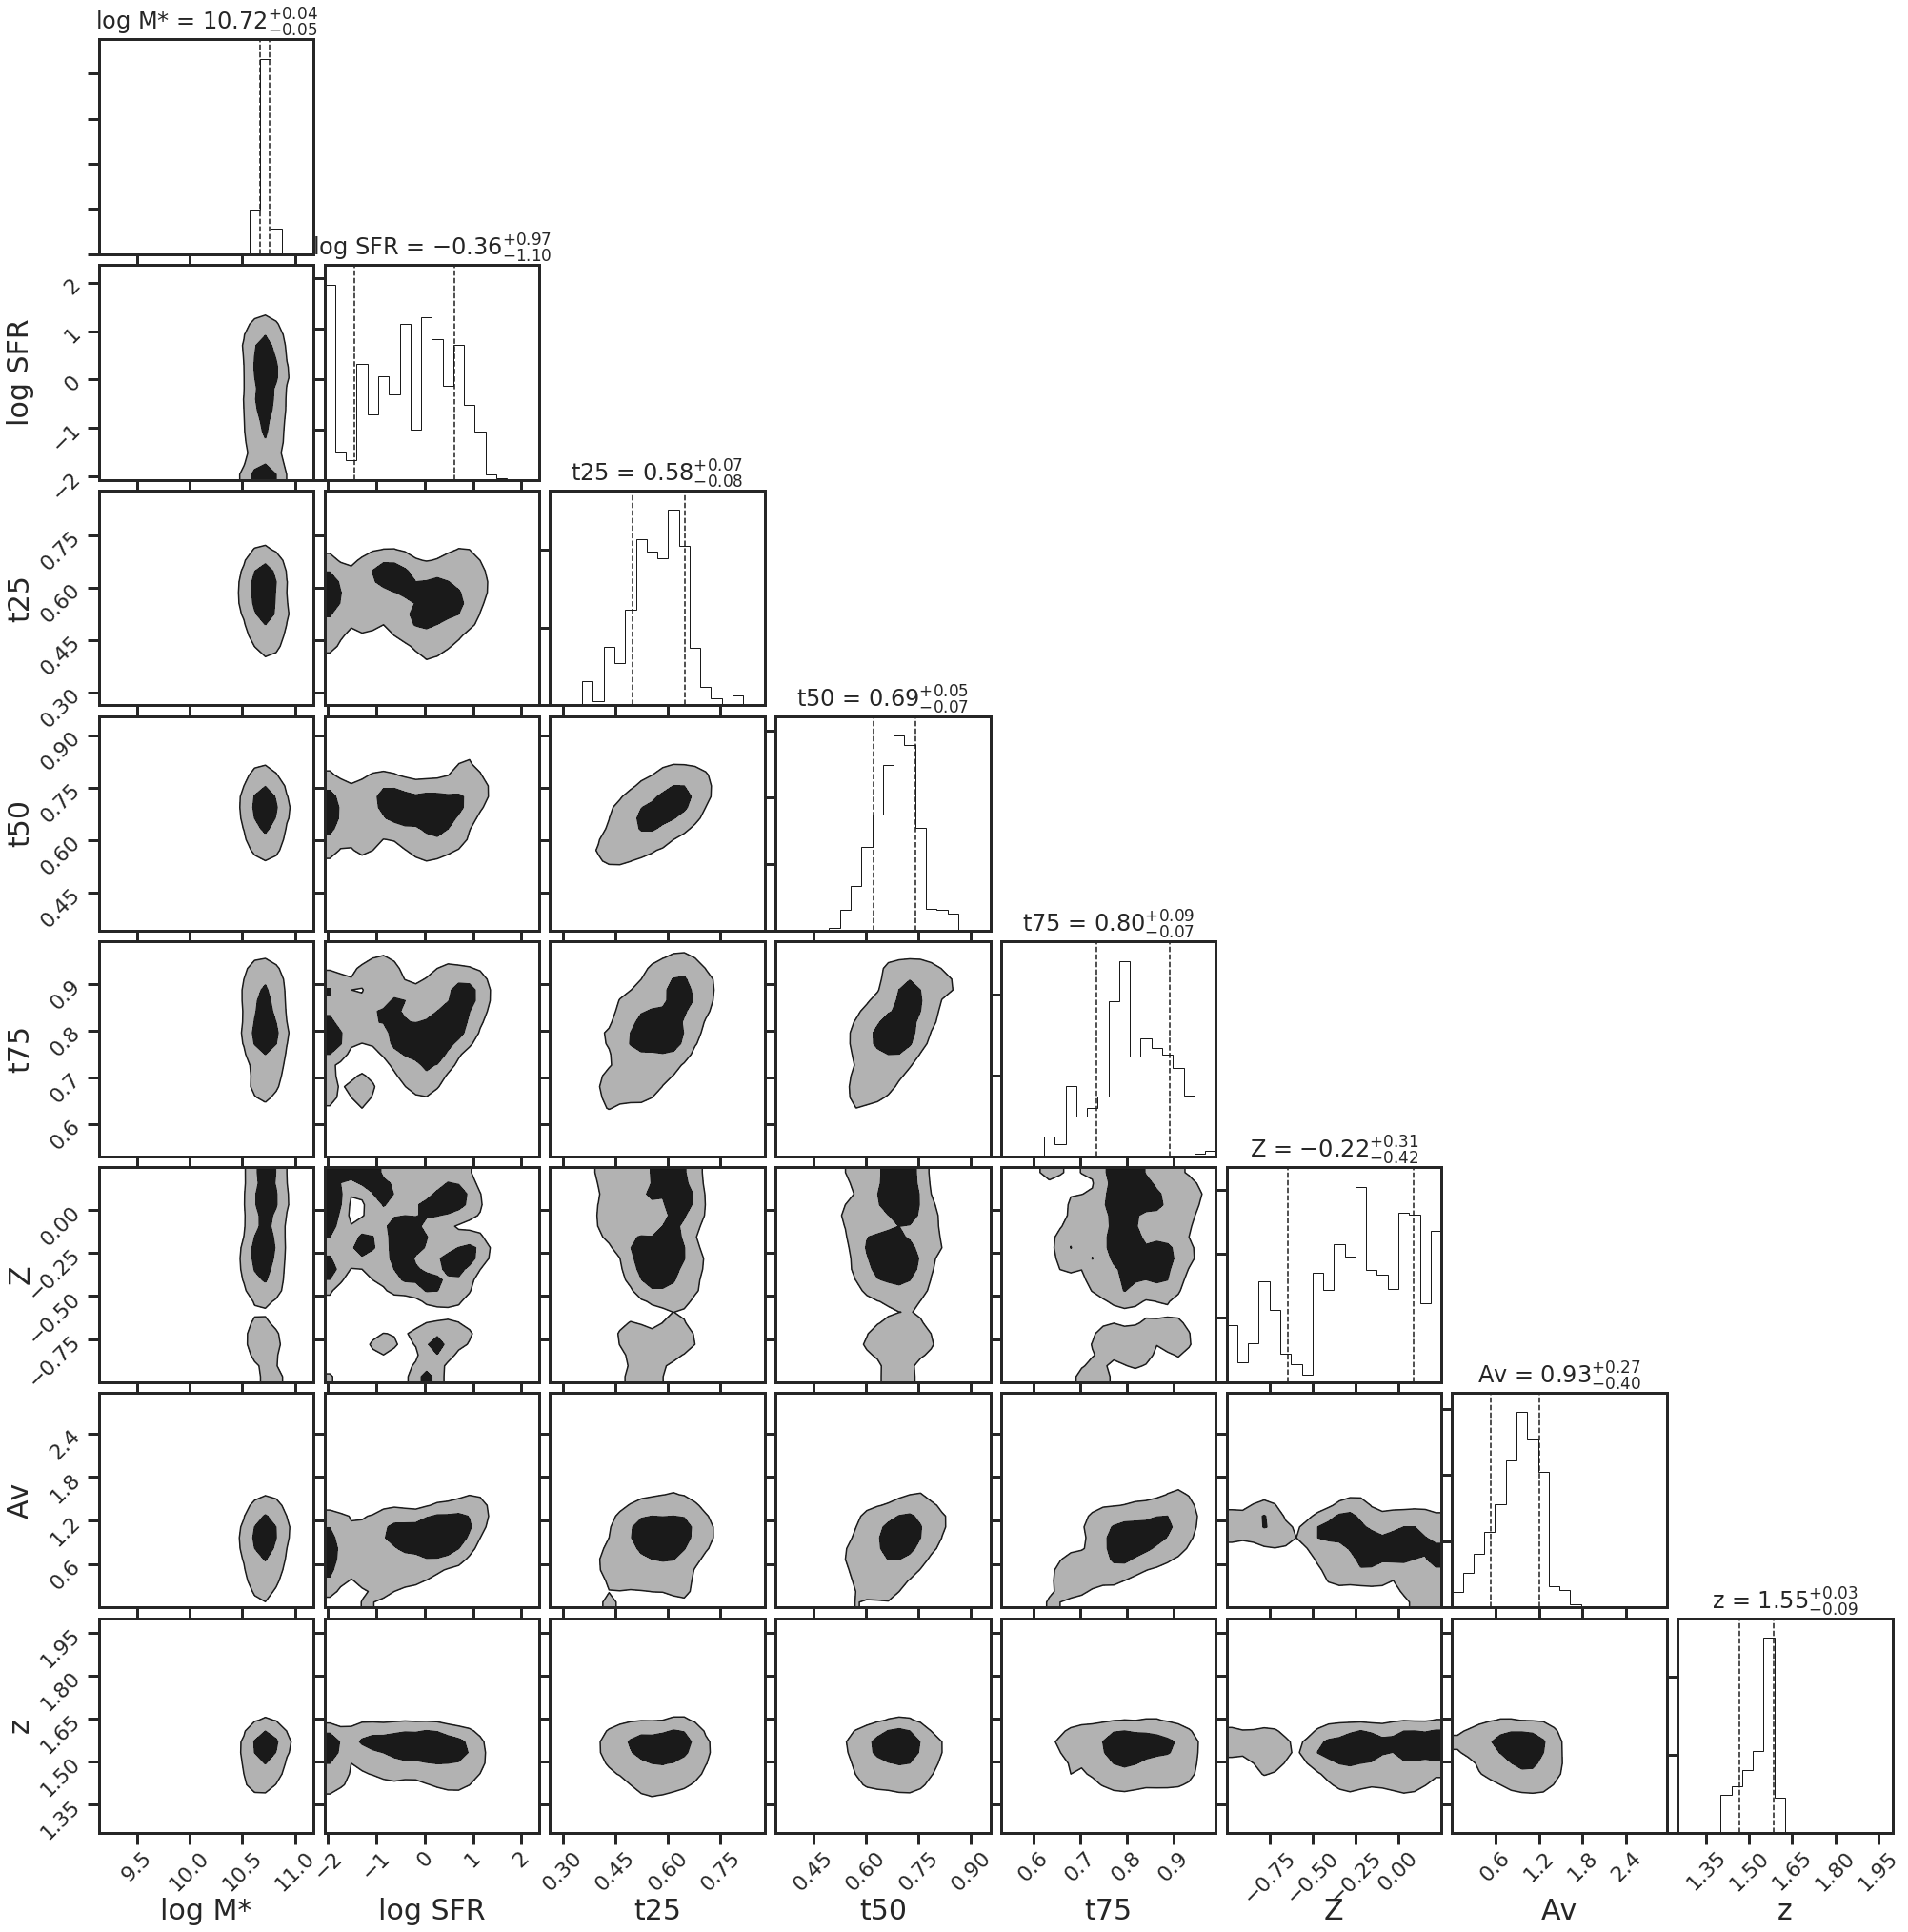

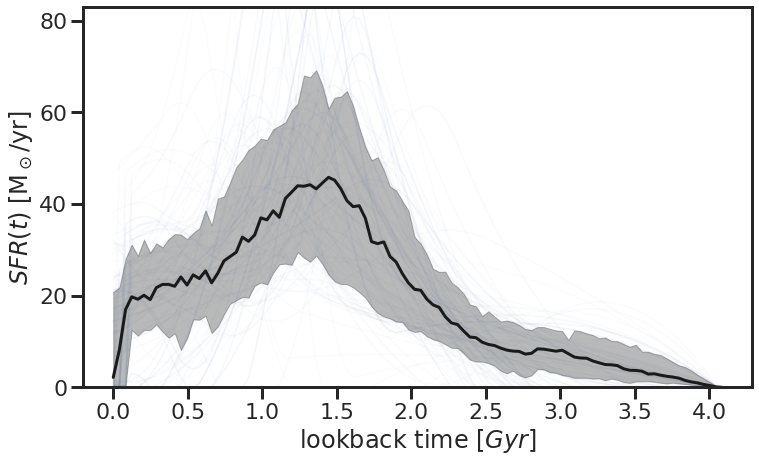

In [38]:
gal_id = 4
SNR = 10

sed = sed_fnus[gal_id,0:]
sed_err = sed/SNR
#sed_err = sed_err + 0.01

time_start = time.time()

sedfit = db.SedFit(sed, sed_err, atlas, zbest = 1.50, deltaz=0.1)
#sedfit = db.SedFit(sed, sed_err, atlas)
sedfit.evaluate_likelihood()
sedfit.evaluate_posterior_percentiles()

time_end = time.time()

print('time taken: %.2f sec' %(time_end-time_start))

filt_centers = np.array([8968,11584,14072,15081,15900,19982,28000,36251,38298,42869,44718,48195])

figure = sedfit.plot_posterior_spec(filt_centers, priors, ngals = 10)
plt.ylim(3e-1,)
plt.show()

sedfit.plot_posteriors()
plt.show()

figure = sedfit.plot_posterior_SFH(sedfit.z[0],ngals = 100)
plt.show()